<a href="https://colab.research.google.com/github/flytanisha/102153037-SESS_LE1/blob/main/102153037_TanishaMaheshwary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: **Tanisha Maheshwary**  
Email: `tmaheshwary_be21@thapar.edu`  
Roll No: **102153037**  
Group: **4CO28**  
Start Timestamp: YYYYMMDD-HHMM  

## Question

  Consider the paper: <https://arxiv.org/abs/1804.03209>

  1. Read and summarise the paper in about 50 words.
  2. Download the dataset in the paper, statistically analyse and
     describe it, so that it may be useful for posterity. (Include code
     snippets in your .ipynb file to evidence your analysis.)
  3. Train a classifier so that you are able to distinguish the commands
     in the dataset.
  4. Report the performance results using standard benchmarks.
  5. Record about 30 samples of each command in your voice and create a
     new dataset (including a new user id for yourself).  You may use a
     timer on your computer to synchronise.
  6. Fine tune your classifier to perform on your voice.
  7. Report the results.

## Solution

**1. Read and summarize**

The paper introduces the "Speech Commands" dataset, which is designed for improving keyword spotting and speech recognition. It contains 65,000 audio recordings from over 2,600 speakers, covering 12 different keywords. The dataset includes diverse speech samples from various environments and accents, making it useful for training models to recognize specific words in real-world conditions. It is openly available for research, helping researchers build and test their speech recognition systems more effectively.

**2. Download the dataset in the paper, statistically analyse and describe it, so that it may be useful for posterity. (Include code snippets in your .ipynb file to evidence your analysis.)**

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
import os
import pathlib
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

In [2]:
# data set loading
!wget -O dataset.tar.gz http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz


--2024-09-11 06:36:26--  http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.142.207, 74.125.195.207, 172.253.117.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.142.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2428923189 (2.3G) [application/gzip]
Saving to: ‘dataset.tar.gz’

dataset.tar.gz      100%[===================>]   2.26G   183MB/s    in 16s     

2024-09-11 06:36:42 (149 MB/s) - ‘dataset.tar.gz’ saved [2428923189/2428923189]



In [9]:
# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [12]:
# Extract the tar.gz file
import tarfile
tar_file_path = 'dataset.tar.gz'  # Replace with the path to your tar.gz file
extracted_dir = 'speech_commands_dataset'  # Directory to extract to

# Check if the directory already exists to avoid re-extracting
if not os.path.exists(extracted_dir):
    with tarfile.open(tar_file_path, 'r:gz') as tar:
        tar.extractall(extracted_dir)
        print(f"Extracted to {extracted_dir}")

# List the contents of the extracted folder
commands = np.array(tf.io.gfile.listdir(extracted_dir))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store') & (commands != '_background_noise_')]

print('Commands:', commands)

Extracted to speech_commands_dataset
Commands: ['no' 'right' 'left' 'zero' 'seven' 'forward' 'six' 'two' 'wow' 'happy'
 'four' 'one' 'down' 'sheila' 'learn' 'go' 'bed' 'validation_list.txt'
 'yes' 'on' 'house' 'bird' 'nine' 'stop' 'three' 'up' 'dog' 'backward'
 'testing_list.txt' 'tree' 'LICENSE' 'five' 'marvin' 'off' 'eight' 'cat'
 'follow' 'visual']


In [14]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='speech_commands_dataset',
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 105835 files belonging to 36 classes.
Using 84668 files for training.
Using 21167 files for validation.

label names: ['_background_noise_' 'backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight'
 'five' 'follow' 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left'
 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six'
 'stop' 'three' 'tree' 'two' 'up' 'visual' 'wow' 'yes' 'zero']


In [16]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000, 1)
(64,)


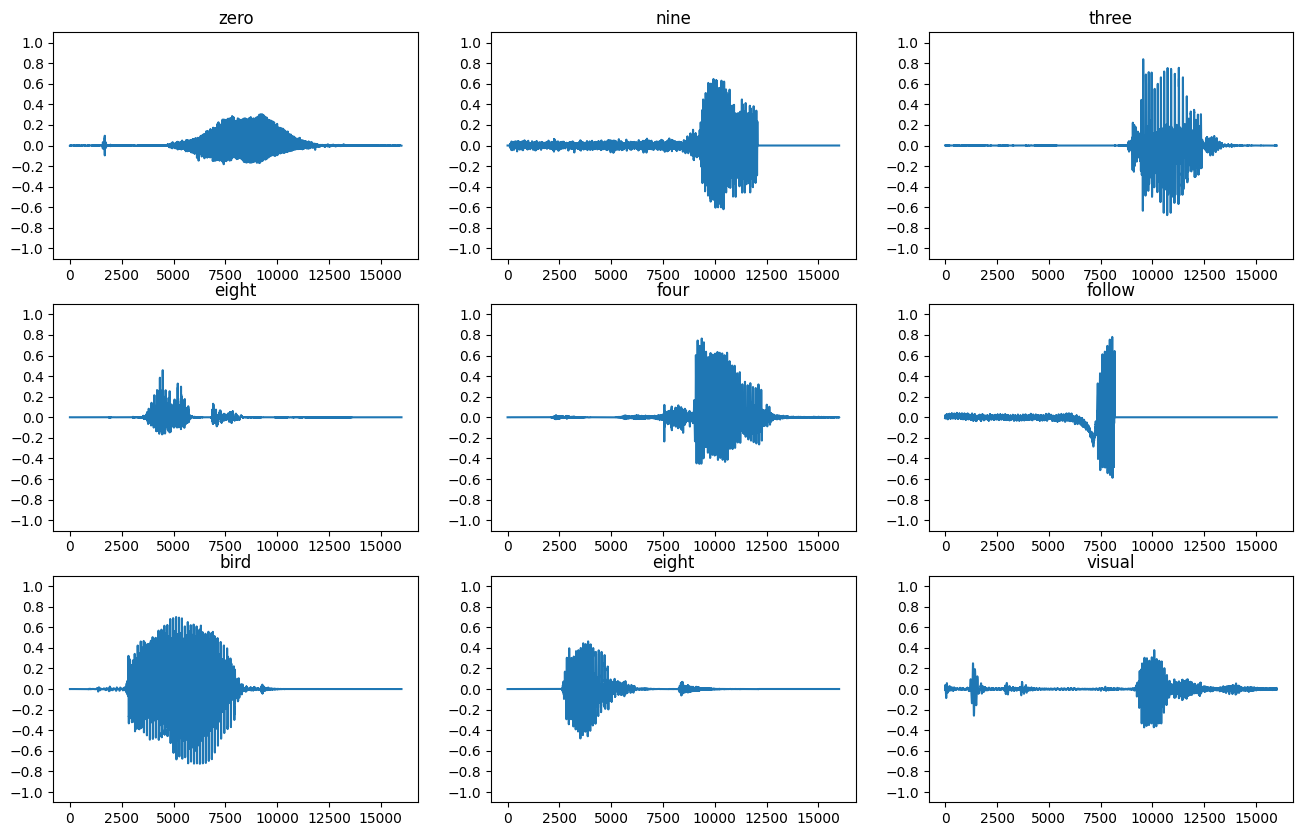

In [17]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [87]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [88]:
spectrogram = get_spectrogram(waveform)

Label: zero
Waveform length: 16000
Waveform min: -0.181793212890625
Waveform max: 0.304168701171875
First few samples: [-0.00158691 -0.0017395  -0.00234985 -0.00247192 -0.00228882 -0.00274658
 -0.00228882 -0.00195312 -0.00262451 -0.00265503]
Audio playback of dataset audio


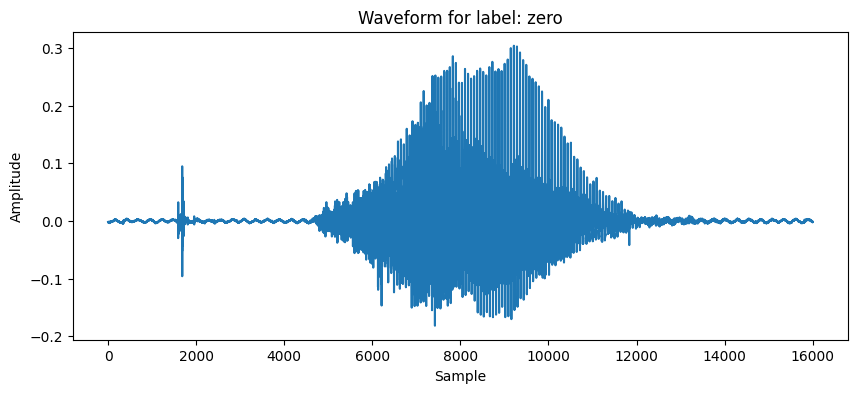

Label: nine
Waveform length: 16000
Waveform min: -0.618896484375
Waveform max: 0.646240234375
First few samples: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Audio playback of dataset audio


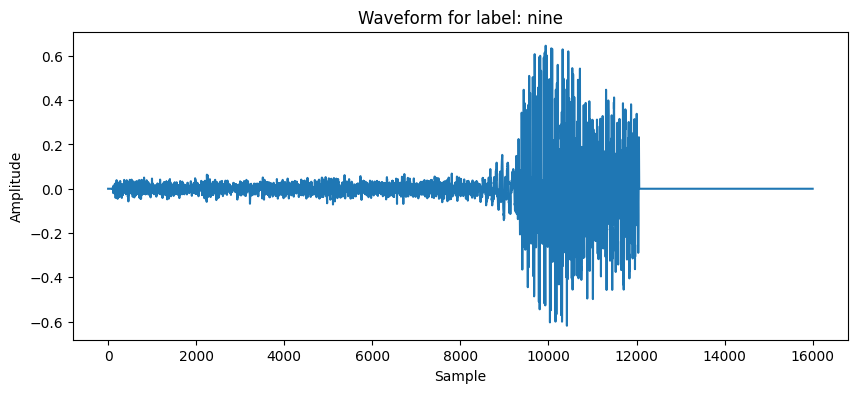

Label: three
Waveform length: 16000
Waveform min: -0.676239013671875
Waveform max: 0.838226318359375
First few samples: [ 0.0000000e+00 -5.1879883e-04  2.4414062e-04 -1.8310547e-04
  1.8310547e-04  7.6293945e-04  1.2207031e-04  3.9672852e-04
  7.3242188e-04  9.1552734e-05]
Audio playback of dataset audio


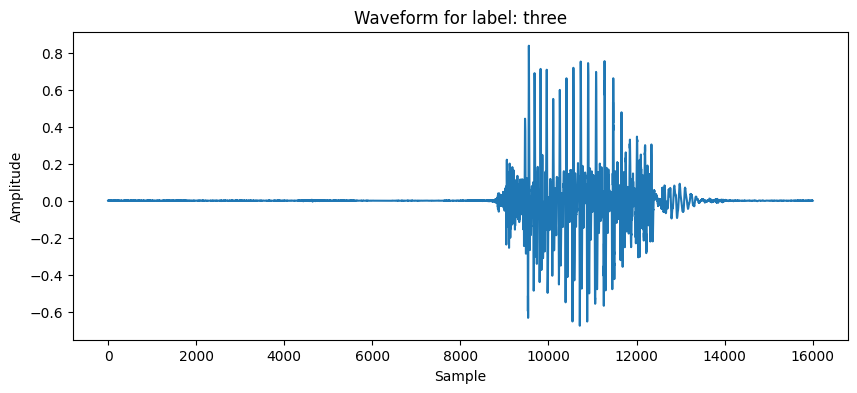

Label: eight
Waveform length: 16000
Waveform min: -0.166229248046875
Waveform max: 0.457366943359375
First few samples: [9.1552734e-05 1.2207031e-04 9.1552734e-05 6.1035156e-05 0.0000000e+00
 6.1035156e-05 9.1552734e-05 6.1035156e-05 0.0000000e+00 6.1035156e-05]
Audio playback of dataset audio


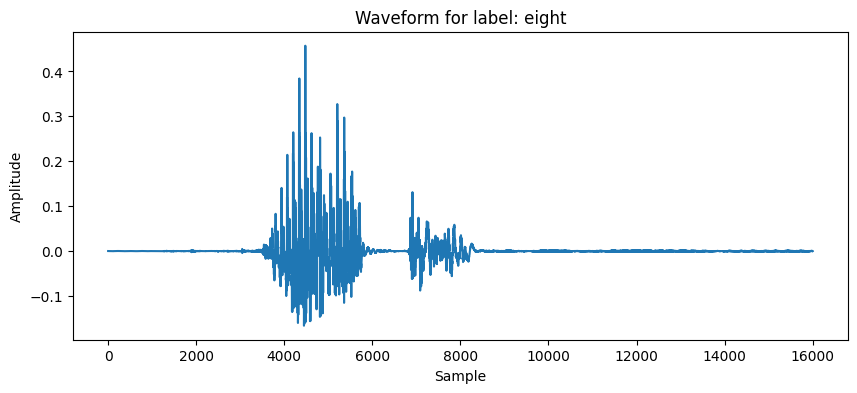

Label: four
Waveform length: 16000
Waveform min: -0.451904296875
Waveform max: 0.765106201171875
First few samples: [-1.8310547e-04  0.0000000e+00  9.1552734e-05  0.0000000e+00
 -1.2207031e-04 -1.8310547e-04 -1.5258789e-04 -6.1035156e-05
 -6.1035156e-05 -2.1362305e-04]
Audio playback of dataset audio


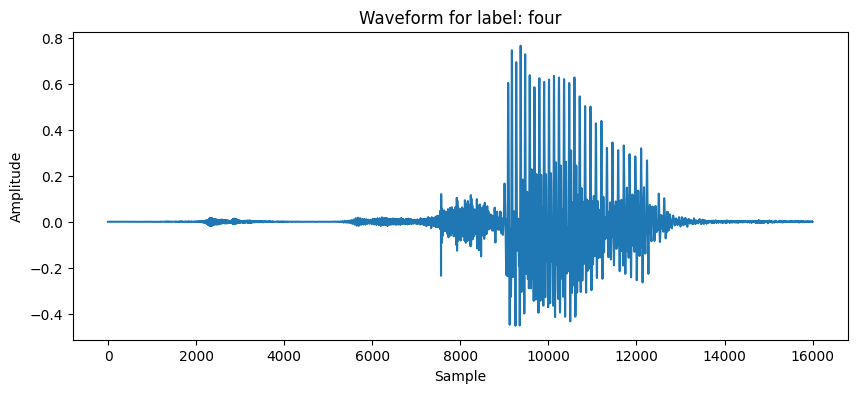

In [29]:
import tensorflow as tf
from IPython import display
import numpy as np
import matplotlib.pyplot as plt

def get_spectrogram(waveform):
    frame_length = 256
    frame_step = 128

    if frame_length > tf.shape(waveform)[0]:
        frame_length = tf.shape(waveform)[0]

    spectrogram = tf.signal.stft(
        waveform, frame_length=frame_length, frame_step=frame_step)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

def pad_or_truncate_waveform(waveform, desired_length=256):
    current_length = tf.shape(waveform)[0]
    if current_length < desired_length:
        paddings = [[0, desired_length - current_length]]
        waveform = tf.pad(waveform, paddings, mode='CONSTANT')
    elif current_length > desired_length:
        waveform = waveform[:desired_length]
    return waveform

import numpy as np
import tensorflow as tf
from IPython import display
import matplotlib.pyplot as plt

# Inspect dataset audio files directly
for i in range(5):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]

    # Convert waveform to 1D tensor
    waveform = tf.squeeze(waveform)

    # Print basic information
    print(f'Label: {label}')
    print(f'Waveform length: {tf.shape(waveform)[0].numpy()}')
    print(f'Waveform min: {tf.reduce_min(waveform).numpy()}')
    print(f'Waveform max: {tf.reduce_max(waveform).numpy()}')
    print('First few samples:', waveform[:10].numpy())

    # Ensure that waveform is non-empty and correctly loaded
    if tf.shape(waveform)[0] == 0:
        print('Error: Waveform is empty.')
    else:
        # Check audio playback
        sampling_rate = 16000  # Ensure this matches your dataset's sampling rate
        print('Audio playback of dataset audio')
        display.display(display.Audio(waveform, rate=sampling_rate))

    # Plot waveform for visualization
    plt.figure(figsize=(10, 4))
    plt.plot(waveform.numpy())
    plt.title(f'Waveform for label: {label}')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()


In [30]:
# train

In [72]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

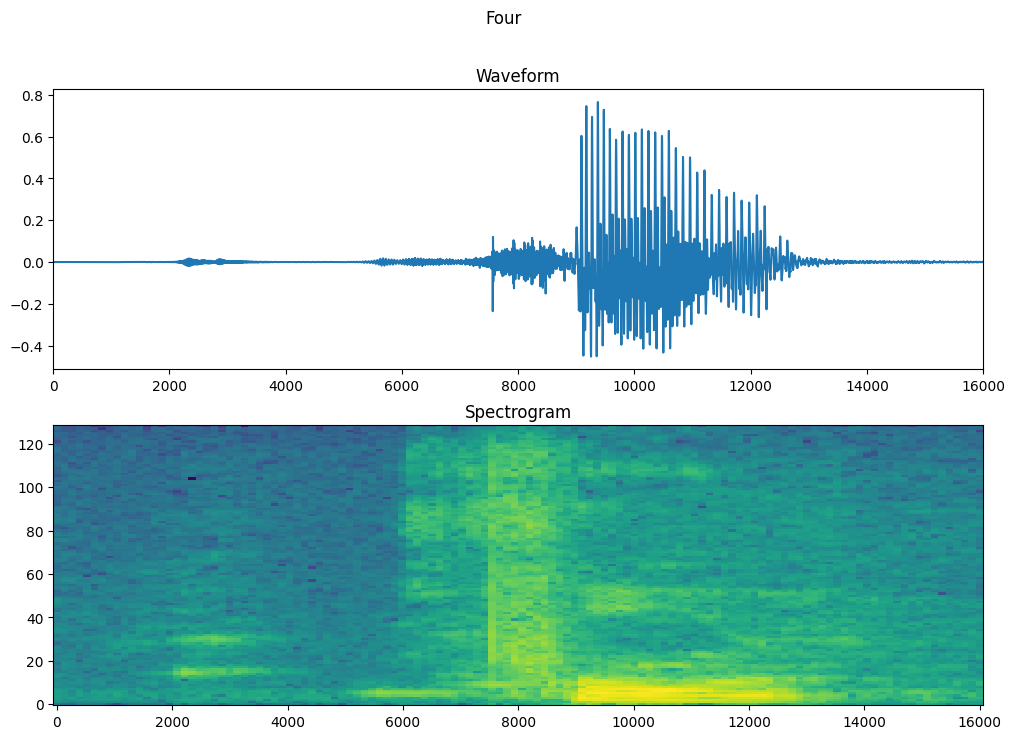

In [75]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [78]:
import torchaudio.transforms as T

def get_spectrogram(audio):
    mel_spectrogram = T.MelSpectrogram(sample_rate=16000, n_mels=128)
    return mel_spectrogram(audio)


In [79]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

AttributeError: 'Subset' object has no attribute 'map'